<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Random Forest (RF) Modeling 
</p>

In [1]:
# Libraries for data manipulation and visualization
import numpy as np                               # For numerical operations
import pandas as pd                              # For data manipulation
import matplotlib.pyplot as plt                  # For plotting
import seaborn as sns                            # For advanced data visualization

# Libraries for model building and evaluation
from sklearn.ensemble import RandomForestRegressor  # For Random Forest Regression
from sklearn.metrics import (                   # For model evaluation metrics
    mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error, 
    median_absolute_error
)
from sklearn.model_selection import KFold, train_test_split  # For cross-validation and splitting data

# Set seed for reproducibility
np.random.seed(50)

In [2]:
# Define the path to the dataset
dataset_path = '../../all_data_files/cleaned_dataset_per_device.csv'

# Load the dataset
try:
    df = pd.read_csv(dataset_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"File not found at the specified path: {dataset_path}")
    import sys
    sys.exit()

# Display dataset information
print("\nDataset Information:")
df.info()
print("\nFirst Five Rows of the Dataset:")
display(df.head())

Dataset loaded successfully.

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 749214 entries, 0 to 749213
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         749214 non-null  object 
 1   device_id    749214 non-null  object 
 2   co2          749214 non-null  float64
 3   humidity     749214 non-null  float64
 4   pm25         749214 non-null  float64
 5   pressure     749214 non-null  float64
 6   temperature  749214 non-null  float64
 7   rssi         749214 non-null  float64
 8   snr          749214 non-null  float64
 9   SF           749214 non-null  int64  
 10  frequency    749214 non-null  float64
 11  f_count      749214 non-null  float64
 12  p_count      749214 non-null  float64
 13  toa          749214 non-null  float64
 14  distance     749214 non-null  int64  
 15  c_walls      749214 non-null  int64  
 16  w_walls      749214 non-null  int64  
 17  exp_pl       749

,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
0,2024-09-26 11:00:52.542462+00:00,ED3,633.0,54.22,0.58,300.41,23.85,-71.0,12.2,10,867.9,94.0,104.0,0.452608,18,1,2,88.4,-83.454107,-71.254107
1,2024-09-26 11:01:52.383162+00:00,ED3,645.0,54.18,0.32,300.48,23.87,-74.0,12.5,9,867.7,95.0,105.0,0.246784,18,1,2,91.4,-86.737602,-74.237602
2,2024-09-26 11:02:52.425491+00:00,ED3,648.0,54.23,0.58,300.50,23.88,-76.0,12.2,9,867.1,96.0,106.0,0.246784,18,1,2,93.4,-88.454107,-76.254107
3,2024-09-26 11:02:52.426016+00:00,ED3,648.0,54.23,0.58,300.50,23.88,-76.0,12.2,9,867.1,96.0,106.0,0.246784,18,1,2,93.4,-88.454107,-76.254107
4,2024-09-26 11:03:52.481201+00:00,ED3,645.0,54.25,0.33,300.50,23.90,-76.0,13.2,9,868.3,97.0,107.0,0.246784,18,1,2,93.4,-89.403045,-76.203045


In [3]:
# Define feature columns and target
feature_columns = [
    'distance', 'frequency', 'c_walls', 'w_walls', 
    'co2', 'humidity', 'pm25', 'pressure', 
    'temperature', 'snr'
]
target_column = 'exp_pl'

# Verify that all required columns exist
missing_columns = set(feature_columns + [target_column]) - set(df.columns)
if missing_columns:
    raise ValueError(f"The following required columns are missing in the dataset: {missing_columns}")

# Extract features and target
all_features = df[feature_columns].values
PL_all = df[target_column].values

# Perform train-test split (80-20 split)
X_train_all, X_test_all, PL_train_all, PL_test_all = train_test_split(
    all_features, PL_all, test_size=0.2, random_state=50
)

print("Train-test split completed.")

Train-test split completed.


In [10]:
# Define Random Forest model
def create_rf_model():
    """Creates a Random Forest model with OOB enabled."""
    return RandomForestRegressor(
        n_estimators=200,  
        criterion='squared_error',
        max_depth=3,      
        max_features='log2',
        random_state=50,  
        n_jobs=-1,       
        min_samples_split=10, 
        min_samples_leaf=5, 
        min_impurity_decrease=0.001,
        bootstrap=True,      
        oob_score=True 
    )

# Instantiate the model
rf_model = create_rf_model()

# Train the model
print("Training Random Forest model...")
rf_model.fit(X_train_all, PL_train_all)
print("\nTraining Completed")

# Retrieve OOB score
oob_score = rf_model.oob_score_
print(f"Random Forest model training completed with OOB Score: {oob_score:.4f}")

Training Random Forest model...

Training Completed
Random Forest model training completed with OOB Score: 0.8333


In [5]:
# Evaluate the model on training and test data
PL_train_pred = rf_model.predict(X_train_all)
PL_test_pred = rf_model.predict(X_test_all)

# Calculate metrics
train_mse = mean_squared_error(PL_train_all, PL_train_pred)
test_mse = mean_squared_error(PL_test_all, PL_test_pred)
train_r2 = r2_score(PL_train_all, PL_train_pred)
test_r2 = r2_score(PL_test_all, PL_test_pred)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(PL_test_all, PL_test_pred)
test_median_ae = median_absolute_error(PL_test_all, PL_test_pred)

# Create a results DataFrame
results = pd.DataFrame({
    'Metric': ['Training Loss (MSE)', 'Test Loss (MSE)', 'Test RMSE', 'R² Score', 
               'Test MAPE (%)', 'Test Median AE'],
    'Value': [train_mse, test_mse, test_rmse, test_r2, test_mape * 100, test_median_ae]
})

print("\nModel Evaluation Metrics:")
display(results)


Model Evaluation Metrics:


,Metric,Value
0,Training Loss (MSE),58.838439
1,Test Loss (MSE),58.579536
2,Test RMSE,7.653727
3,R² Score,0.835241
4,Test MAPE (%),6.307927
5,Test Median AE,4.674157


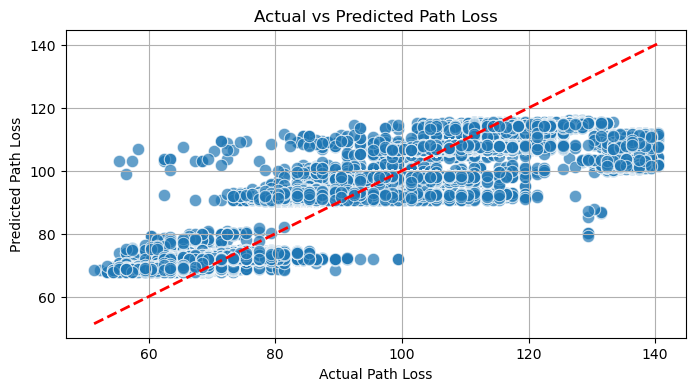

In [6]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 4))
sns.scatterplot(x=PL_test_all, y=PL_test_pred, alpha=0.7, edgecolor='w', s=80)
plt.plot([PL_test_all.min(), PL_test_all.max()], [PL_test_all.min(), PL_test_all.max()], 'r--', lw=2)
plt.xlabel('Actual Path Loss')
plt.ylabel('Predicted Path Loss')
plt.title('Actual vs Predicted Path Loss')
plt.grid(True)
plt.show()

In [7]:
# Cell 7: Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
fold = 1

for train_idx, val_idx in kf.split(X_train_all):
    print(f"Training fold {fold}...")

    # Split the data for the current fold
    X_train_fold, X_val_fold = X_train_all[train_idx], X_train_all[val_idx]
    PL_train_fold, PL_val_fold = PL_train_all[train_idx], PL_train_all[val_idx]

    # Create and train a new Random Forest model
    rf_model_cv = create_rf_model()
    rf_model_cv.fit(X_train_fold, PL_train_fold)

    # Predict and evaluate on validation set
    PL_val_pred = rf_model_cv.predict(X_val_fold)
    val_mse = mean_squared_error(PL_val_fold, PL_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(PL_val_fold, PL_val_pred)
    val_mape = mean_absolute_percentage_error(PL_val_fold, PL_val_pred)
    val_median_ae = median_absolute_error(PL_val_fold, PL_val_pred)

    # Append metrics
    cv_results.append({
        'Fold': fold,
        'Validation Loss (MSE)': round(val_mse, 4),
        'Validation RMSE': round(val_rmse, 4),
        'R² Score': round(val_r2, 4),
        'Validation MAPE (%)': round(val_mape * 100, 2),
        'Validation Median AE': round(val_median_ae, 4)
    })

    print(f"Fold {fold} - MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}, MAPE: {val_mape*100:.2f}%, Median AE: {val_median_ae:.4f}")
    fold += 1

# Create a DataFrame from CV results
cv_results_df = pd.DataFrame(cv_results)

# Display cross-validation results
print("\nK-Fold Cross-Validation Results:")
display(cv_results_df)

# Summary statistics
cv_summary = cv_results_df.agg(['mean', 'std']).round(4).reset_index()
cv_summary.rename(columns={'index': 'Metric'}, inplace=True)
print("\nCross-Validation Summary:")
display(cv_summary)

Training fold 1...
Fold 1 - MSE: 58.4768, RMSE: 7.6470, R²: 0.8351, MAPE: 6.27%, Median AE: 4.6346
Training fold 2...
Fold 2 - MSE: 59.0466, RMSE: 7.6842, R²: 0.8341, MAPE: 6.29%, Median AE: 4.6299
Training fold 3...
Fold 3 - MSE: 58.2388, RMSE: 7.6314, R²: 0.8358, MAPE: 6.26%, Median AE: 4.6287
Training fold 4...
Fold 4 - MSE: 58.6793, RMSE: 7.6602, R²: 0.8352, MAPE: 6.31%, Median AE: 4.6420
Training fold 5...
Fold 5 - MSE: 59.1371, RMSE: 7.6901, R²: 0.8337, MAPE: 6.28%, Median AE: 4.6066

K-Fold Cross-Validation Results:


,Fold,Validation Loss (MSE),Validation RMSE,R² Score,Validation MAPE (%),Validation Median AE
0,1,58.4768,7.6470,0.8351,6.27,4.6346
1,2,59.0466,7.6842,0.8341,6.29,4.6299
2,3,58.2388,7.6314,0.8358,6.26,4.6287
3,4,58.6793,7.6602,0.8352,6.31,4.6420
4,5,59.1371,7.6901,0.8337,6.28,4.6066



Cross-Validation Summary:


,Metric,Fold,Validation Loss (MSE),Validation RMSE,R² Score,Validation MAPE (%),Validation Median AE
0,mean,3.0000,58.7157,7.6626,0.8348,6.2820,4.6284
1,std,1.5811,0.3785,0.0247,0.0009,0.0192,0.0132
